In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pickle
import shap
import pandas as pd
import copy
import torch.nn as nn
import shap
import seaborn as sns
%env HDF5_USE_FILE_LOCKING=FALSE

import sys
sys.path.insert(1, '../../models/PFN')
from dataset_pfn import PFNDataset
from pfn_model import ParticleFlowNetwork as Model
# print the JS visualization code to the notebook
shap.initjs()

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
#Parameters to change, can change model_type to 'best' or 'last'
dataset = ''
extra_name = ''
model_type = 'best'
preprocessed=True
#Training/Testing path
if dataset == '':
    test_path = "../../datasets/test.h5"
    features=3
#model path
model_path = '../../models/PFN/models/PFN_'+model_type+dataset+extra_name

#Loading training/testing dataset
test_set = PFNDataset(test_path, preprocessed)
##loading model
model = Model(features)
model.load_state_dict(torch.load(model_path))
model.eval()

ParticleFlowNetwork(
  (phi): Sequential(
    (0): Sequential(
      (0): Linear(in_features=3, out_features=100, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=256, bias=True)
      (1): ReLU()
    )
  )
  (fc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=256, out_features=100, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
    (3): Linear(in_features=100, out_features=2, bias=True)
    (4): Softmax(dim=1)
  )
)

In [54]:
sys.path.insert(1, '../../models/Multi-Body')
from multidataset import MultiDataset

#Only used for cross correlation matrix
#Parameters to change
use_jet_pt = True
use_jet_mass = True
tau_x_1 = False
N = 8
#Testing path
test_path = '../../datasets/multi_body_tau_data/test_0.npy'

#Loading testing dataset
tau_set = MultiDataset(test_path, N, use_jet_pt, use_jet_mass, tau_x_1)
tau_data, tau_label = tau_set[:]
tau_classes = []
if not tau_x_1:
    for i in range(N-1):
        if i != N-2:
            tau_classes.append('tau_'+str(i+1)+'_'+str(0.5))
            tau_classes.append('tau_'+str(i+1)+'_'+str(1))
            tau_classes.append('tau_'+str(i+1)+'_'+str(2))
        else:
            tau_classes.append('tau_'+str(i+1)+'_'+str(1))
            tau_classes.append('tau_'+str(i+1)+'_'+str(2))
    if use_jet_pt:
        tau_classes.append('jet_pt')
    if use_jet_mass:
        tau_classes.append('jet_mass')
else:
    for i in range(N-1):
        tau_classes.append('tau_'+str(i+1)+'_'+str(1))
    if use_jet_pt:
        tau_classes.append('jet_pt')
    if use_jet_mass:
        tau_classes.append('jet_mass')
        
test_data, _, test_label = test_set[:]
test_data_sig = test_data[test_label[:,1]==1]
test_data_bkg = test_data[test_label[:,1]==0]

sig_indices = torch.where(test_data_sig[:, 7][:,0]==0)[0]
bkg_indices = torch.where(test_data_bkg[:, 7][:,0]==0)[0]

In [4]:
#Signal or background (sig or bkg)
#only need to run twice for signal and background separation
background = 'sig'
if background == 'sig':
    test_data, test_mask, test_label = test_set[:]
    test_data_sig = test_data[test_label[:,1]==1]
    test_mask_sig = test_mask[test_label[:,1]==1]
    with torch.no_grad():
        test_data_sig = torch.flatten(test_data_sig, start_dim=0, end_dim=1)
        latent_space_test_sig = model._modules['phi'].forward(test_data_sig)
        latent_space_test_sig = torch.stack(torch.split(latent_space_test_sig.permute(1, 0), 200, dim=1), 0)
        latent_space_test_sig = latent_space_test_sig * test_mask_sig.bool().float()
        latent_space_test_sig = latent_space_test_sig.sum(-1).cuda()
elif background == 'bkg':
    test_data, test_mask, test_label = test_set[:]
    test_data_bkg = test_data[test_label[:,1]==0]
    test_mask_bkg = test_mask[test_label[:,1]==0]
    with torch.no_grad():
        test_data_bkg = torch.flatten(test_data_bkg, start_dim=0, end_dim=1)
        latent_space_test_bkg = model._modules['phi'].forward(test_data_bkg)
        latent_space_test_bkg = torch.stack(torch.split(latent_space_test_bkg.permute(1, 0), 200, dim=1), 0)
        latent_space_test_bkg = latent_space_test_bkg * test_mask_bkg.bool().float()
        latent_space_test_bkg = latent_space_test_bkg.sum(-1).cuda()

In [93]:
def removeOutliers(x, outlierConstant=1.5):
    quantiles = np.quantile(x, (0.25, 0.75),axis=0)
    IQR = (quantiles[1]-quantiles[0])*1.5
    result = np.where((x>=quantiles[0]-IQR)&(x<=quantiles[1]+IQR), x, 0)
    
    return result

#part_dataset: Choose from 'sig' or 'bkg'
#zero_bias: Choose whether to do zero_bias on LRP
#lrp_type: Choose from 'zero', 'epsilon', 'gamma', for LRP-zero, LRP-epsilon, LRP-gamma
#graphs specify which graphs you want in a list. You can only choose from 'abs_bar', 'bar', 'dist', 
# 'corr', 'diff_bar','diff_abs_bar', 'diff_dist', 'diff_corr'
# save details whether you want to save it or not
def make_graphs(model_copy, latent_space_test, test_label, part_dataset, dataset_name, tau_indices, zero_bias=False, lrp_type='zero', lrp_param=None,
               graphs=['abs_bar', 'bar', 'dist', 'corr'], figsize=(10, 10), options = '', tau_data=None, tau_classes=None, extra_name=False, save=False):
    if extra_name:
        if zero_bias:
            options += '_zero_bias'
        if lrp_type == 'gamma':
            options += '_LRP-' + lrp_type + '_' + str(lrp_param)
        elif lrp_type == 'epsilon':
            options += '_LRP-' + lrp_type + '_' + str(lrp_param)
        elif lrp_type == 'zero':
            options += '_LRP-' + lrp_type
    classes = np.array([])
    model_copy = model_copy.cpu()
    latent_space_test = latent_space_test.cpu()
    n_latent=256
    for i in range(n_latent):
        classes=np.append(classes, 'z'+str(i))
          
    if part_dataset == 'sig':
        col=1
    if part_dataset == 'bkg':
        col=0
    
    #layer_names = ['fc.0', 'fc.1', 'fc.2', 'fc.3']
    L=4 #num layers
    A = [latent_space_test]+[None]*L
    for i in range(L):
        A[i+1] = model_copy._modules['fc'][i].forward(A[i])
    def newlayer(layer,g):
        layer = copy.deepcopy(layer)
        with torch.no_grad():
            try: layer.weight = nn.Parameter(g(layer.weight))
            except AttributeError: pass
            if zero_bias:
                try: nn.init.constant_(layer.bias, 0.0)
                except AttributeError: pass
            else:
                try: layer.bias   = nn.Parameter(g(layer.bias))
                except AttributeError: pass
        return layer
    #Combine Dense+Activation functions
    #A[4] uses pre-sigmoid output
    B = [A[0], A[1], A[2], A[3], A[4][:,col][...,None]]
    # Backpropagate relevance scores
    if lrp_type == 'zero':
        rho = lambda p: p;                       incr = lambda z: z
    elif lrp_type == 'gamma':
        rho = lambda p: p + lrp_param*p.clamp(min=0); incr = lambda z: z
    elif lrp_type == 'epsilon':
        rho = lambda p: p;                       incr = lambda z: z+lrp_param
    R = [None]*4 + [B[-1]]
    # Iterate over the layers in reverse order
    for l in range(0,4)[::-1]:    
        B[l] = (B[l].data).requires_grad_(True)

        if l == 3:
            z = incr(newlayer(model_copy._modules['fc'][l], rho).forward(B[l]))
            z = z[:,col][...,None]
        else:
            z = newlayer(model_copy._modules['fc'][l][0], rho).forward(B[l])
            z = incr(model_copy._modules['fc'][l][1].forward(z))
        #Gets rid of zeroes in denominators
        inds_nz = z != 0
        R1_sum = torch.sum(R[l+1].clone())
        R2_sum_nz = torch.sum(R[l+1][inds_nz].clone())
        R[l+1] = R[l+1].clone()*R1_sum/R2_sum_nz
        z = torch.where(z == torch.FloatTensor([0]), torch.FloatTensor([1]), z)
        R[l + 1] = torch.where(z == torch.FloatTensor([0]), torch.FloatTensor([0]), R[l+1])
        s = (R[l+1]/z).data                                    # step 2
        (z*s).sum().backward(); c = B[l].grad                  # step 3
        R[l] = (B[l]*c).data                                   # step 4
        
    
    #Plots relevances as normalized
    normal_rel = np.empty_like(R[0])
    #Normalizes relevances for each sample
    normal_rel = (R[0]/np.sum(R[0].detach().numpy(), 1)[:, np.newaxis]).detach().numpy()
    if part_dataset == 'sig': 
        type_set = 'Signal'
    else: 
        type_set = 'Background'
    idx=0
    
    if 'abs_bar' in graphs:
        normal_rel_no_outlier = removeOutliers(normal_rel)
        plt.figure(idx, figsize=figsize)
        abs_relevances = np.nanmean(np.abs(normal_rel_no_outlier), 0) #Takes mean across all jets
        df_rel = pd.DataFrame(dict(params=classes, rels=abs_relevances))
        df_rel_sorted = df_rel.sort_values('rels') #Sorts relevance values
        # creating the abs bar plot
        max_display = 20
        plt.barh('params', 'rels', data = df_rel_sorted.tail(max_display), color ='blue')
        plt.tight_layout()
        plt.xlabel("Relevance Score")
        plt.ylabel("Parameters")
        plt.title("PFN Absolute Value "+type_set+" LRP values")
        idx+=1
        if save:
            plt.savefig("figures/PFN"+dataset_name+"/LRP_"+part_dataset+"_absbar"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return
    if 'bar' in graphs:
        normal_rel_no_outlier = removeOutliers(normal_rel)
        plt.figure(idx, figsize=figsize)
        abs_relevances = np.nanmean(normal_rel_no_outlier, 0) #Takes mean across all jets
        df_rel = pd.DataFrame(dict(params=classes, rels=abs_relevances))
        df_rel_sorted = df_rel.sort_values('rels') #Sorts relevance values
        # creating the abs bar plot
        max_display = 20
        plt.barh('params', 'rels', data = df_rel_sorted.tail(max_display), color ='blue')
        plt.xlabel("Relevance Score")
        plt.ylabel("Parameters")
        plt.title("PFN "+type_set+" LRP values")
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/PFN"+dataset_name+"/LRP_"+part_dataset+"_bar"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return
    if 'dist' in  graphs:
        normal_rel_no_outlier = removeOutliers(normal_rel)
        plt.figure(idx, figsize=figsize)
        shap.summary_plot(normal_rel_no_outlier, sig, feature_names=classes, max_display = 20, plot_type = "dot", show=False)
        plt.title("PFN "+type_set+" LRP values")
        plt.gcf().axes[-1].set_aspect(100)
        plt.gcf().axes[-1].set_box_aspect(100)
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/PFN"+dataset_name+"/LRP_"+part_dataset+"_dist"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return
    if 'corr' in graphs:
        list_of_important_latent = [127, 231, 250, 65, 2, 210, 25, 222, 13, 94, 62, 45, 236, 157, 170, 199, 54, 212, 96, 216,
                                   223, 57, 61, 221, 121, 22, 107, 183, 43, 175, 70, 37, 224, 148, 56, 179, 72, 125, 184, 
                                   205, 38, 229, 112, 186]
        list_of_important_latent.sort()
        normal_rel_no_outlier = removeOutliers(normal_rel)
        print(np.isnan(normal_rel_no_outlier).any())
        plt.figure(idx, figsize=figsize)
        df_rel_total = pd.DataFrame(normal_rel_no_outlier, columns=classes).iloc[list_of_important_latent, list_of_important_latent]
        corrmat = df_rel_total.corr()
        print(corrmat.iloc[:,22])
        sns.heatmap(corrmat, center=0, annot=True, cmap='bwr', fmt='.1f')
        plt.title("PFN "+type_set+" LRP Correlation Matrix")
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/PFN"+dataset_name+"/LRP_"+part_dataset+"_corr"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return
    if 'feature_corr' in graphs:
        list_of_important_latent = [127, 231, 250, 65, 2, 210, 25, 222, 13, 94, 62, 45, 236, 157, 170, 199, 54, 212, 96, 216,
                                   223, 57, 61, 221, 121, 22, 107, 183, 43, 175, 70, 37, 224, 148, 56, 179, 72, 125, 184, 
                                   205, 38, 229, 112, 186]
        list_of_important_latent.sort()
        plt.figure(idx, figsize=figsize)
        df_rel_total = pd.DataFrame(latent_space_test.detach().numpy(), columns=classes)
        corrmat = df_rel_total.corr().iloc[list_of_important_latent, list_of_important_latent]
        sns.heatmap(corrmat, center=0, annot=True, cmap='bwr', fmt='.1f')
        plt.title("PFN "+type_set+" Feature Correlation Matrix")
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/PFN"+dataset_name+"/LRP_"+part_dataset+"_feature_corr"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return
    if 'box_whisker' in graphs:
        plt.figure(idx, figsize=figsize)
        df_rel_total = pd.DataFrame(removeOutliers(normal_rel), columns=classes)
        sorted_index = df_rel_total.abs().mean().sort_values(ascending=False).index
        df_rel = pd.DataFrame(normal_rel, columns=classes)
        df_rel_total = df_rel[sorted_index].iloc[:, :20]
        sns.boxplot(data=df_rel_total, orient='h', showfliers=False)
        plt.title("PFN "+type_set+" LRP Box and Whisker Distribution")
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/PFN"+dataset_name+"/LRP_"+part_dataset+"_box_whisker"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return 
    if 'cross_corr' in graphs:
        list_of_important_latent = [127, 231, 250, 65, 2, 210, 25, 222, 13, 94, 62, 45, 236, 157, 170, 199, 54, 212, 96, 216,
                                   223, 57, 61, 221, 121, 22, 107, 183, 43, 175, 70, 37, 224, 148, 56, 179, 72, 125, 184, 
                                   205, 38, 229, 112, 186]
        list_of_important_latent.sort()
        plt.figure(idx, figsize=figsize)
        df_rel_total = pd.DataFrame(np.delete(latent_space_test.detach().numpy(), tau_indices, 0), columns=classes).iloc[:, list_of_important_latent]
        tau_rel_total = pd.DataFrame(tau_data, columns=tau_classes)
        corrmat = pd.concat([df_rel_total, tau_rel_total], axis=1).corr().loc[df_rel_total.columns, tau_rel_total.columns]
        sns.heatmap(corrmat, center=0, annot=True, cmap='bwr', fmt='.1f')
        plt.title("PFN "+type_set+" Tau Cross Correlation Matrix")
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/PFN"+dataset_name+"/LRP_"+part_dataset+"_tau_cross_corr"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return 
    if 'hist' in graphs:
        normal_rel_no_outlier = removeOutliers(normal_rel)
        plt.figure(idx, figsize=(25,400))
        n_bins = 100
        plt.style.use('seaborn-deep')
        f, a = plt.subplots(64, 4, constrained_layout=True, figsize=(25,400))
        f.suptitle('Testing PFN Latent Space '+type_set+' LRP Distributions', fontsize=16)
        a = a.ravel()
        for idx,ax in enumerate(a):
            #ax.axes.yaxis.set_ticklabels([])
            ax.hist(normal_rel_no_outlier[:, idx], bins=n_bins, alpha=0.5, label = type_set)
            ax.set_title(classes[idx] + ' (LRP)')
            ax.legend(loc='upper right')
        # creating the abs bar plot
        idx+=1
        if save:
            plt.savefig("figures/relevance_hist/"+"/LRP_"+part_dataset+"_hist"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return
    #Combine Dense+Activation functions
    #A[4] uses pre-sigmoid output
    B = [A[0], A[1], A[2], A[3], A[4][:,1-col][...,None]]
    # Backpropagate relevance scores
    if lrp_type == 'zero':
        rho = lambda p: p;                       incr = lambda z: z
    elif lrp_type == 'gamma':
        rho = lambda p: p + lrp_param*p.clamp(min=0); incr = lambda z: z
    elif lrp_type == 'epsilon':
        rho = lambda p: p;                       incr = lambda z: z+lrp_param
    R_ = [None]*4 + [B[-1]]
    # Iterate over the layers in reverse order
    for l in range(0,4)[::-1]:    
        B[l] = (B[l].data).requires_grad_(True)

        if l == 3:
            z = incr(newlayer(model_copy._modules['fc'][l], rho).forward(B[l]))
            z = z[:,1-col][...,None]
        else:
            z = newlayer(model_copy._modules['fc'][l][0], rho).forward(B[l])
            z = incr(model_copy._modules['fc'][l][1].forward(z))
        #Gets rid of zeroes in denominators
        inds_nz = z != 0
        R1_sum = torch.sum(R_[l+1].clone())
        R2_sum_nz = torch.sum(R_[l+1][inds_nz].clone())
        R_[l+1] = R_[l+1].clone()*R1_sum/R2_sum_nz
        z = torch.where(z == torch.FloatTensor([0]), torch.FloatTensor([1]), z)
        R_[l + 1] = torch.where(z == torch.FloatTensor([0]), torch.FloatTensor([0]), R_[l+1])
        s = (R_[l+1]/z).data                                    # step 2
        (z*s).sum().backward(); c = B[l].grad                  # step 3
        R_[l] = (B[l]*c).data                                   # step 4
        
    #Plots relevances as normalized
    #Normalizes difference in relevances using pre-sigmoid output
    normal_rel = (R[0]-R_[0])/(A[4][:,col][...,None]-A[4][:,1-col][...,None])
    
    if 'diff_abs_bar' in graphs:
        normal_rel_no_outlier = removeOutliers(normal_rel)
        plt.figure(idx, figsize=figsize)
        abs_relevances = np.nanmean(np.abs(normal_rel_no_outlier), 0) #Takes mean across all jets
        df_rel = pd.DataFrame(dict(params=classes, rels=abs_relevances))
        df_rel_sorted = df_rel.sort_values('rels') #Sorts relevance values
        # creating the abs bar plot
        max_display = 20
        plt.barh('params', 'rels', data = df_rel_sorted.tail(max_display), color ='blue')
        plt.tight_layout()
        plt.xlabel("Relevance Score")
        plt.ylabel("Parameters")
        plt.title("PFN Absolute Value "+type_set+" Difference LRP values")
        idx+=1
        if save:
            plt.savefig("figures/PFN"+dataset_name+"/LRP_"+part_dataset+"_diff_absbar"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return
    if 'diff_bar' in graphs:
        normal_rel_no_outlier = removeOutliers(normal_rel)
        plt.figure(idx, figsize=figsize)
        abs_relevances = np.nanmean(normal_rel_no_outlier, 0) #Takes mean across all jets
        df_rel = pd.DataFrame(dict(params=classes, rels=abs_relevances))
        df_rel_sorted = df_rel.sort_values('rels') #Sorts relevance values
        # creating the abs bar plot
        max_display = 20
        plt.barh('params', 'rels', data = df_rel_sorted.tail(max_display), color ='blue')
        plt.xlabel("Relevance Score")
        plt.ylabel("Parameters")
        plt.title("PFN "+type_set+" Difference LRP values")
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/PFN"+dataset_name+"/LRP_"+part_dataset+"_diff_bar"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return
    if 'diff_dist' in  graphs:
        normal_rel_no_outlier = removeOutliers(normal_rel)
        plt.figure(idx, figsize=figsize)
        shap.summary_plot(normal_rel_no_outlier, sig, feature_names=classes, max_display = 20, plot_type = "dot", show=False)
        plt.title("PFN "+type_set+" Difference LRP values")
        plt.gcf().axes[-1].set_aspect(100)
        plt.gcf().axes[-1].set_box_aspect(100)
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/PFN"+dataset_name+"/LRP_"+part_dataset+"_diff_dist"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return
    if 'diff_corr' in graphs:
        list_of_important_latent = [127, 231, 250, 65, 2, 210, 25, 222, 13, 94, 62, 45, 236, 157, 170, 199, 54, 212, 96, 216,
                                   223, 57, 61, 221, 121, 22, 107, 183, 43, 175, 70, 37, 224, 148, 56, 179, 72, 125, 184, 
                                   205, 38, 229, 112, 186]
        list_of_important_latent.sort()
        normal_rel_no_outlier = removeOutliers(normal_rel)
        plt.figure(idx, figsize=figsize)
        df_rel_total = pd.DataFrame(normal_rel_no_outlier, columns=classes).iloc[list_of_important_latent, list_of_important_latent]
        corrmat = df_rel_total.corr()
        sns.heatmap(corrmat, center=0, annot=True, cmap='bwr', fmt='.1f')
        plt.title("PFN "+type_set+" Difference LRP Correlation Matrix")
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/PFN"+dataset_name+"/LRP_"+part_dataset+"_diff_corr"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return
    if 'diff_box_whisker' in graphs:
        plt.figure(idx, figsize=figsize)
        df_rel_total = pd.DataFrame(removeOutliers(normal_rel), columns=classes)
        sorted_index = df_rel_total.mean().sort_values(ascending=False).index
        df_rel = pd.DataFrame(normal_rel, columns=classes)
        df_rel_total = df_rel[sorted_index]
        sns.boxplot(data=df_rel_total, orient='h', showfliers=False)
        plt.title("PFN "+type_set+" Difference LRP Box and Whisker Distribution")
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/PFN"+dataset_name+"/LRP_"+part_dataset+"_diff_box_whisker"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return 

    print("Not applicable graph type")
    return


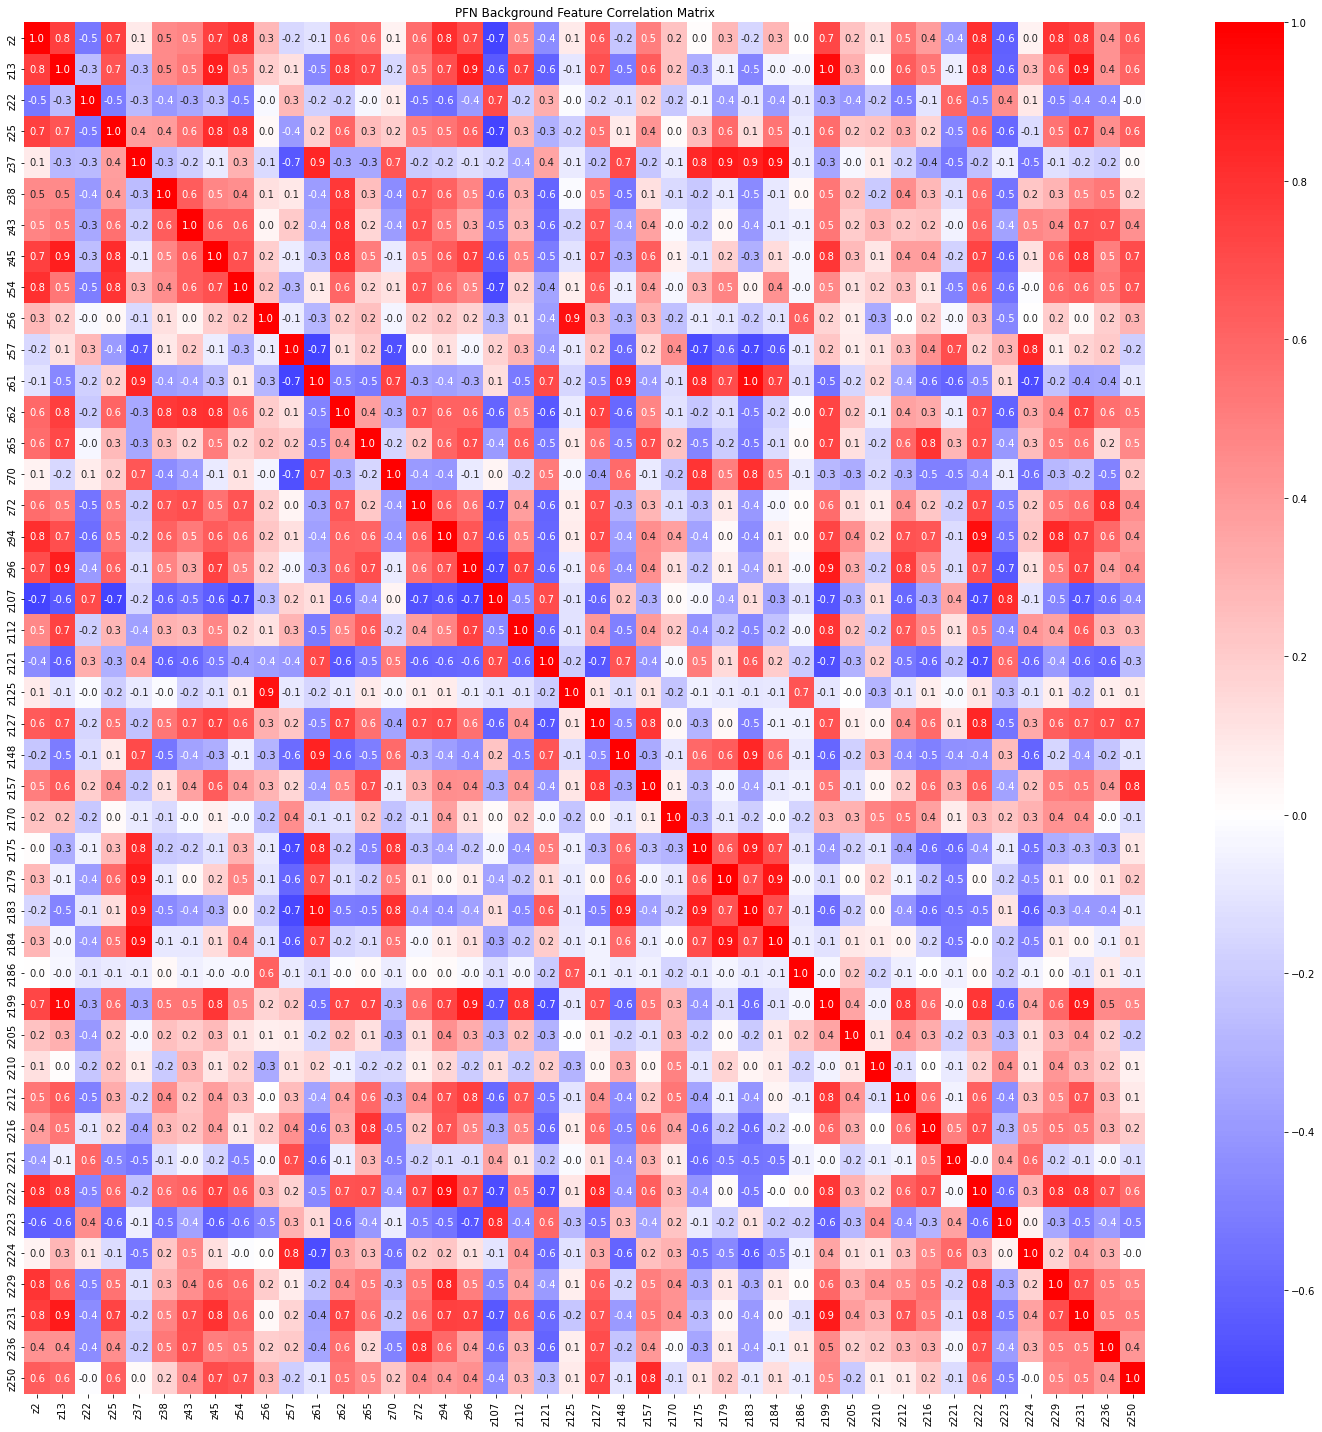

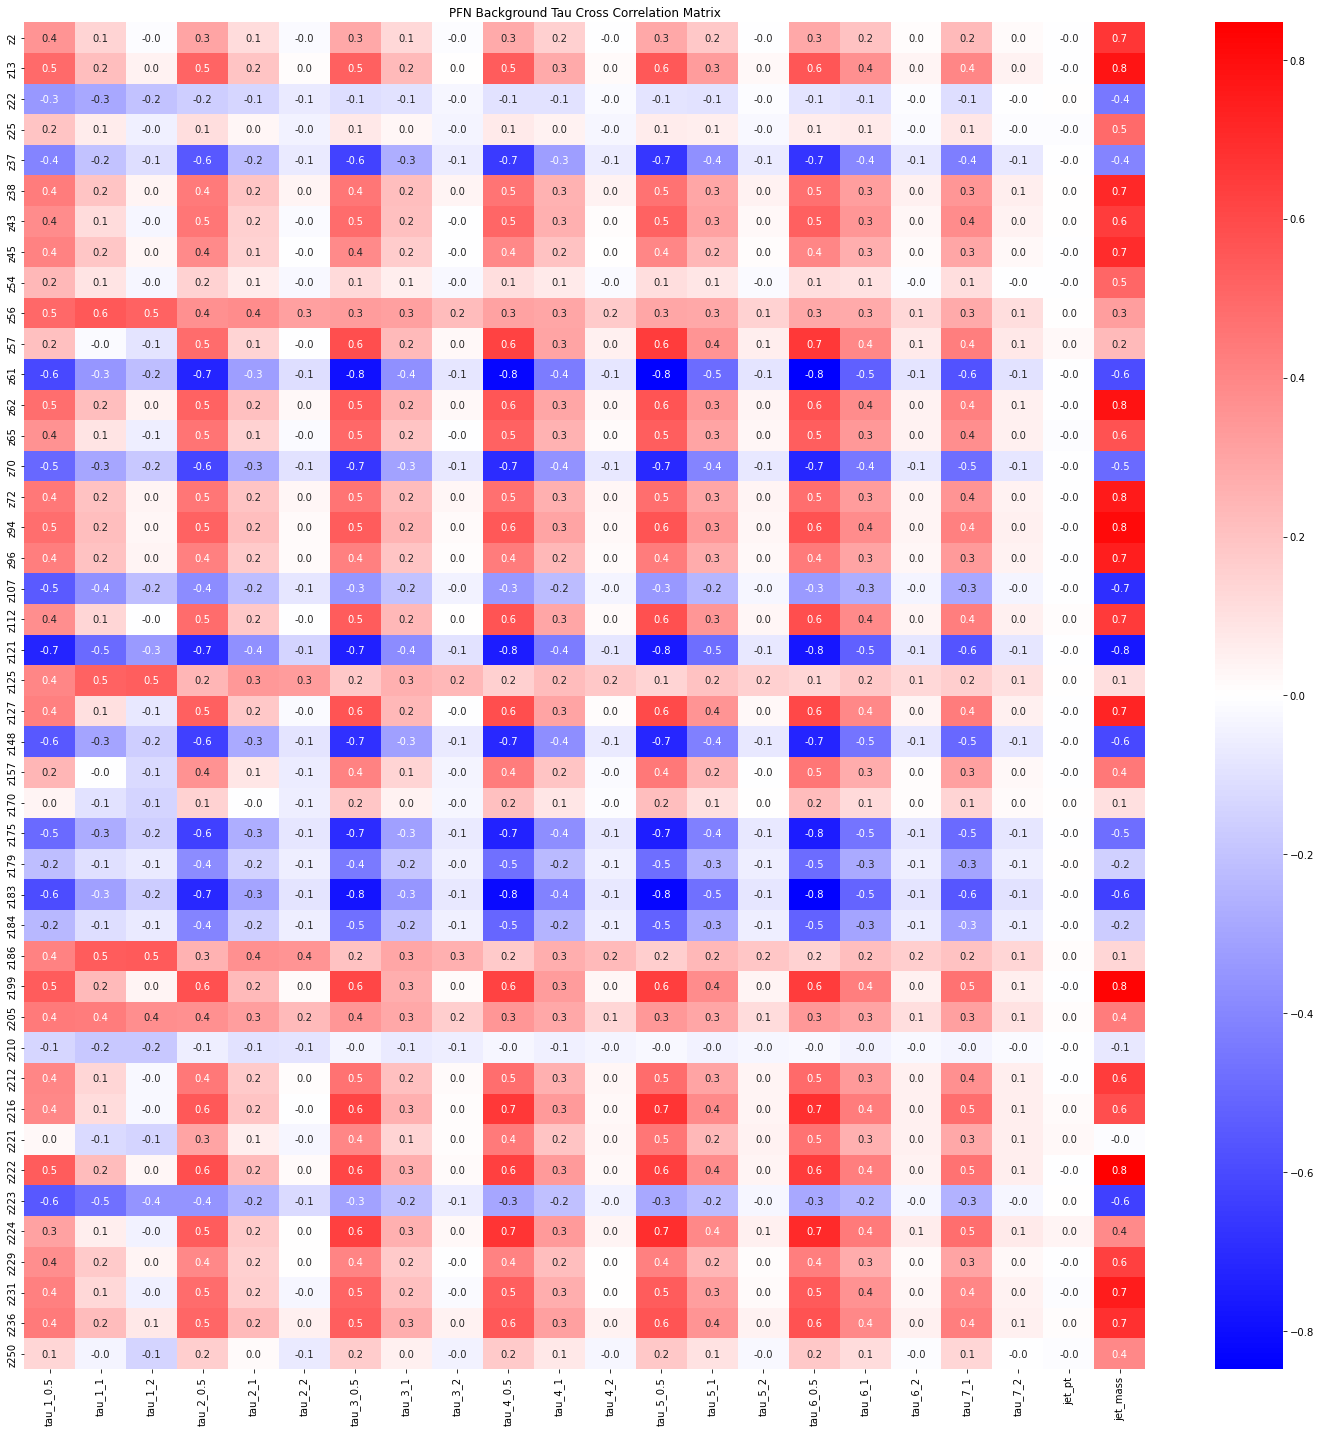

In [94]:
#part_dataset: Choose from 'sig' or 'bkg'
#zero_bias: Choose whether to do zero_bias on LRP
#can specify whether to take relevance of 'latent' or 'params' taken from parameters
#lrp_type: Choose from 'zero', 'epsilon', 'gamma', for LRP-zero, LRP-epsilon, LRP-gamma
#graphs specify which graphs you want in a list. You can only choose from 'abs_bar', 'bar', 'dist', 
# 'corr','box_whisker', 'diff_bar','diff_abs_bar', 'diff_dist', 'diff_corr','diff_box_whisker'
# The ones beggining in diff detail the difference in relevance values of the background/signal output for the part_dataset
# save details whether you want to save it or not
#figsize is the figure size of all plots, options are extra names you can add to end of saved figure 
#when specifying options, suggested to put '_' before the word
#extra_name specifies what LRP type automatically when saving
part_dataset = 'bkg'
zero_bias=False
lrp_type='gamma'
lrp_param=1
graphs=['feature_corr', 'cross_corr']
figsize=(20, 20)
if part_dataset == 'sig':
    latent_space_test = latent_space_test_sig
    tau_indices = sig_indices
    tau_data_ = tau_data[tau_label[:,1]==1]
elif part_dataset == 'bkg':
    latent_space_test = latent_space_test_bkg
    tau_indices = bkg_indices
    tau_data_ = tau_data[tau_label[:,1]==0]

options = ''
save=True
extra_name=False
total = make_graphs(model_copy=model, latent_space_test=latent_space_test, test_label=test_label, part_dataset=part_dataset, dataset_name=dataset, tau_indices=tau_indices,
           zero_bias=zero_bias, lrp_type=lrp_type, lrp_param=lrp_param, graphs=graphs,figsize=figsize, options=options, tau_data =tau_data_, tau_classes=tau_classes, extra_name=extra_name, save=save)

In [36]:
classes = np.array([])
n_latent=256
for i in range(n_latent):
    classes=np.append(classes, 'z'+str(i))
n_bins = 100
plt.style.use('seaborn-deep')
f, a = plt.subplots(64, 4, constrained_layout=True, figsize=(25,400))
f.suptitle('Testing PFN Latent Space Feature Distributions', fontsize=16)
a = a.ravel()
for idx,ax in enumerate(a):
    #ax.axes.yaxis.set_ticklabels([])
    ax.hist(latent_space_test_sig[:, idx].cpu().detach().numpy(), bins=n_bins, alpha=0.5, label = 'Signal')
    ax.hist(latent_space_test_bkg[:, idx].cpu().detach().numpy(), bins=n_bins, alpha=0.5, label = 'Bkg')
    ax.set_title(classes[idx] + ' (feat)')
    ax.legend(loc='upper right')
plt.show()
#Saves feature distribution
#plt.savefig('figures/feature_histograms/latent_space_test_feat_hist'+'.png', dpi = 150, bbox_inches = 'tight')

<Figure size 432x288 with 0 Axes>

In [59]:
torch.where(test_mask[test_label[:,0]==0][:,0][:,6]==0)

(tensor([], dtype=torch.int64),)

In [52]:
len(bkg_indices)+403883-404000

0

In [69]:
['z'+str(i) for i in [127, 231, 250, 65, 2, 210, 25, 222, 13, 94, 62, 45, 236, 157, 170, 199, 54, 212, 96, 216,
                                   223, 57, 61, 221, 121, 22, 107, 183, 43, 175, 70, 37, 224, 148, 56, 179, 72, 125, 184, 
                                   205, 38, 229, 112, 186]]

['z127',
 'z231',
 'z250',
 'z65',
 'z2',
 'z210',
 'z25',
 'z222',
 'z13',
 'z94',
 'z62',
 'z45',
 'z236',
 'z157',
 'z170',
 'z199',
 'z54',
 'z212',
 'z96',
 'z216',
 'z223',
 'z57',
 'z61',
 'z221',
 'z121',
 'z22',
 'z107',
 'z183',
 'z43',
 'z175',
 'z70',
 'z37',
 'z224',
 'z148',
 'z56',
 'z179',
 'z72',
 'z125',
 'z184',
 'z205',
 'z38',
 'z229',
 'z112',
 'z186']